In [65]:
import scipy
import numpy as np
from fitters import *
from tools import *
from plots import *
from projectors import *
set_seaborn({'figure.figsize': (12,6)})
sns.set_style('white')
plt.rcParams['figure.dpi'] = 150
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
def get_data(Ydataset, factor, Xdataset='PHOTO'):
    resX, stim = read_lmc(Xdataset)
    resY, stim = read_lmc(Ydataset)
    X = preprocess(resX, factor=factor, method='mean')
    Y = preprocess(resY, factor=factor, method='mean')

    return X, Y


In [103]:
dt_ms = 2.0
lag_ms = 25
window_factor = 2
beta = 1e-8
factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, lag_ms)
X_series, Y_series = get_data('LMC-BG1', factor)

N = len(X_series)
window = int(dim * window_factor)

thetas, ws = [], []
for i in range(window, N, 1):

    sl = slice(i-window, i)
    Xhan = build_hankel(X_series[sl], dim)
    X0w = Xhan[:, :-1]
    Xpw = Xhan[:, 1:]

    Xp1 = Xpw[-1]
    X01 = np.vstack((X0w, np.ones(X0w.shape[1])))
    reg_dim = dim + 1
    lam = beta * np.eye(reg_dim)

    a = (Xp1 @ X01.T) @ np.linalg.inv((X01 @ X01.T) + lam)
    a, c = a[:-1], a[-1:]
    A = np.eye(dim, k=1)
    A[-1] = a
    w, vl = scipy.linalg.eig(A, left=True, right=False)

    sortorder = np.argsort(np.abs(w))
    w = w[sortorder][::-1]
    theta = vl[:, sortorder][:, -1]
    theta *= np.sign(theta[-1])
    thetas.append(theta)
    ws.append(w)

ws = np.array(ws)
thetas = np.array(thetas)
Xhan = build_hankel(X_series, dim)
theta = np.mean(thetas, axis=0)
P_series = theta.real @ Xhan

Y_series = Y_series[dim:]


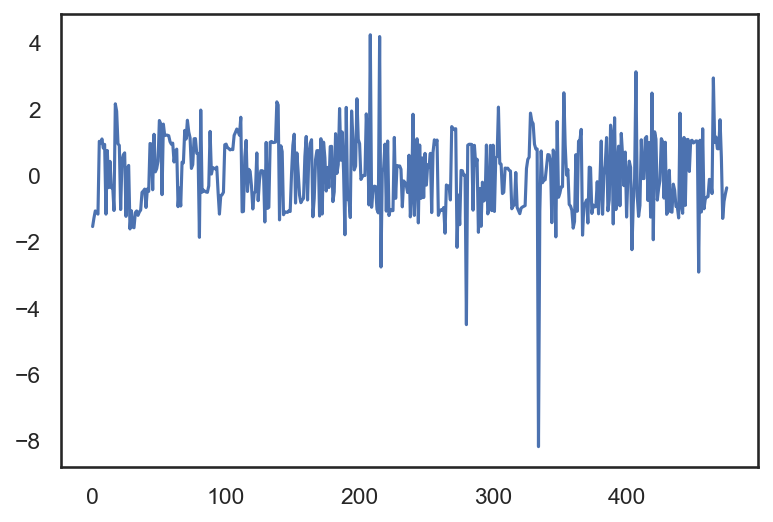

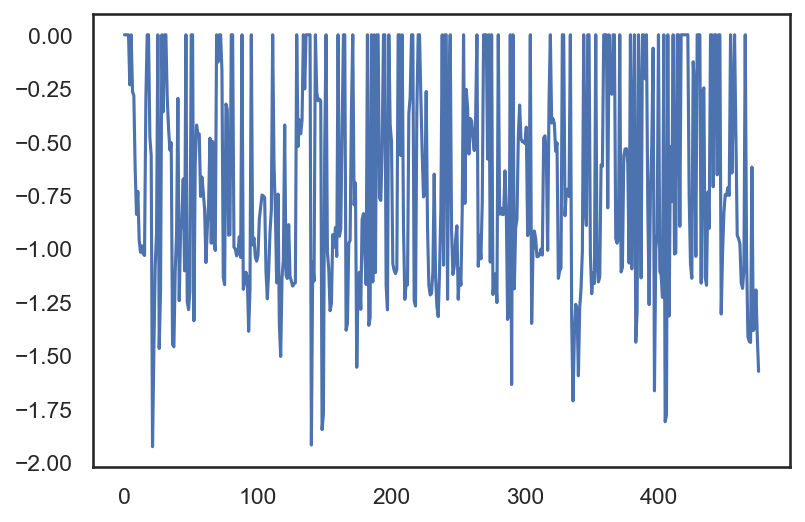

In [104]:
plt.plot(ws[:, 0].real)
plt.show()
plt.plot(ws[:, 0].imag)
plt.show()

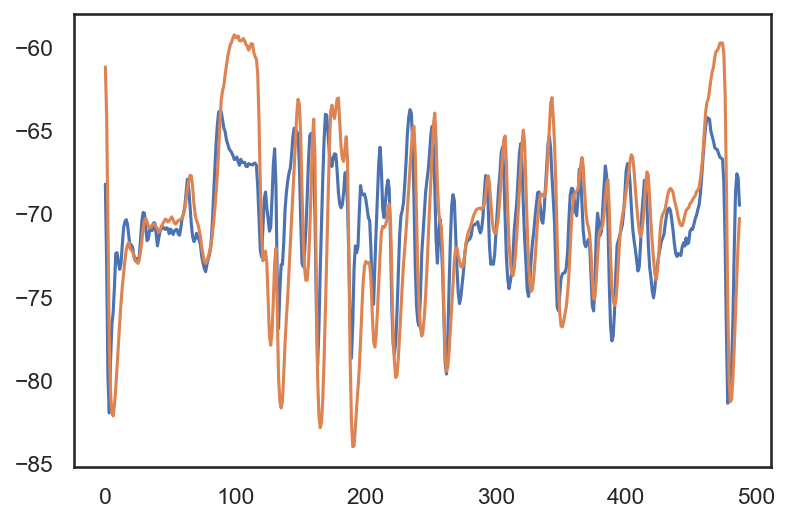

15.10575530750761


In [105]:

P_series_fit = solve_scale_shift(P_series, Y_series)
plt.plot(P_series_fit)
plt.plot(Y_series)
plt.show()
err = mean_square_error(Y_series, P_series_fit)
print(err)

476 -> 112


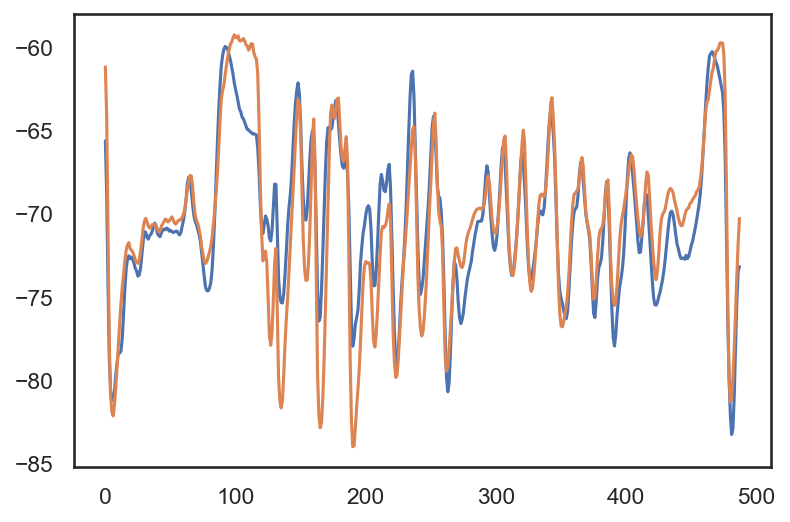

6.078941662537263


In [106]:
thetas_real = thetas[np.linalg.norm(thetas.imag, axis=1) <  0.1]
print(f'{len(thetas)} -> {len(thetas_real)}')
theta_real = np.mean(thetas_real, axis=0)
P_series = theta_real.real @ Xhan

P_series_fit = solve_scale_shift(P_series, Y_series)
plt.plot(P_series_fit)
plt.plot(Y_series)
plt.show()
err = mean_square_error(Y_series, P_series_fit)
print(err)